In [1]:
import flowshape as fs
import igl
import numpy as np
import meshplot as mp
import os
import pandas as pd
# from src.utilities.fin_shape_utils import fit_fin_hull, upsample_fin_point_cloud, plot_mesh
from src.utilities.fin_class_def import FinData
from src.utilities.functions import path_leaf
import glob2 as glob
import meshplot as mp
import trimesh

## Explore basic questions about SH coefficeints
1) Do they register differences in scale?
2) Can we isolate rotational variation?
3) How many coefficients are required to get 'good' reconstructions

### Load fin data

In [2]:
# get list of refined fin mesh objects
root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/"

fin_mesh_list = sorted(glob.glob(os.path.join(root, "point_cloud_data", "processed_fin_data", "*smoothed_fin_mesh*")))
raw_mesh_list = sorted(glob.glob(os.path.join(root, "point_cloud_data", "processed_fin_data", "*raw_fin_mesh*")))
fin_df_list = sorted(glob.glob(os.path.join(root, "point_cloud_data", "processed_fin_data", "*upsampled*")))
fin_df_c_list = sorted(glob.glob(os.path.join(root, "point_cloud_data", "processed_fin_data", "*data.csv")))

In [4]:
file_ind = 5

fin_mesh =trimesh.load(fin_mesh_list[file_ind])
raw_fin_mesh =trimesh.load(raw_mesh_list[file_ind])
fin_df = pd.read_csv(fin_df_list[file_ind])
fin_df_c = pd.read_csv(fin_df_c_list[file_ind])

print(fin_df_c_list[file_ind])

/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/point_cloud_data/processed_fin_data/20240711_01_well0004_time0000_fin_data.csv


### Get fin mesh

In [5]:
#igl.read_triangle_mesh("/home/nick/projects/flowshape/demo/ABal.obj")
v, f =  fin_mesh.vertices.copy(), fin_mesh.faces.copy()
mp.plot(v, f, shading = {"wireframe":True})

/home/nick/miniconda3/envs/flowshape_env/lib/python3.10/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(
/home/nick/miniconda3/envs/flowshape_env/lib/python3.10/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "uint32" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(12.103296…

### Run spherical mapping

In [6]:
# normalize the scaling of the mesh
v = fs.normalize(v)

# run the spherical mapping flow and mobius centering
sv = fs.sphere_map(v, f)

# Now we have a spherical mesh
mp.plot(sv, f, shading = {"wireframe":True})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(8.6426734…

### Calculate the mean curvature

In [7]:
rho = fs.curvature_function(v, sv, f)

mp.plot(v,f, rho )

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0527022…

## SH decomposition

In [8]:
# this utility does the above steps + SH decomposition
weights, Y_mat, vs = fs.do_mapping(v, f, l_max=15)

In [9]:
# This is the array of SH weights
np.set_printoptions(threshold=100)
print(weights)

[ 3.16263489 -0.02155111  0.13984136 ... -0.21007848 -0.24655218
 -0.48506967]


In [12]:
np.min(weights)

-1.5701516966479778

In [45]:
# Y_mat is a matrix used to convert between weights and mesh function
rho2 = Y_mat.dot(weights)
mp.plot(vs,f, c = rho2)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000142…

### Mesh reconstruction

In [46]:
rec2 = fs.reconstruct_shape(vs, f, rho2 )
mp.plot(rec2,f, c = rho2)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.056183…

### Are SH coefficients scale-invariant?
My expectation is yes

In [50]:
v0, f0 = fin_mesh.vertices.copy(), fin_mesh.faces.copy()
v0_big = v0*100

w0, Y_mat, vs = fs.do_mapping(v0, f0, l_max=15)
w0_big, Y_mat, vs = fs.do_mapping(v0_big, f0, l_max=15)

In [51]:
np.all(np.round(w0, 5) == np.round(w0_big, 5))

True

Yep! We will need an extra scaling coefficient to fully recapitulate the data

### Are SH coefficents rotationally invariant?
Expectation is that they are not

In [53]:
from scipy.spatial.transform import Rotation as R
import numpy as np

# Example point cloud (Nx3 array)
# points = np.random.rand(100, 3)

# Generate a random rotation
rotation = R.random()  # Generates a random 3D rotation
rotation_matrix = rotation.as_matrix()

# Rotate the point cloud
# rotated_points = points @ rotation_matrix.T

v1, f1 = fin_mesh.vertices.copy(), fin_mesh.faces.copy()
v1_rot = v1 @ rotation_matrix.T

w1, _, _ = fs.do_mapping(v1, f1, l_max=15)
w1_rot, _, _ = fs.do_mapping(v1_rot, f1, l_max=15)

np.all(np.round(w1, 5) == np.round(w1_rot, 5))

False

Cool cool cool. 

### Look at recon error

In [77]:
from tqdm import tqdm

v2, f2 = fin_mesh.vertices.copy(), fin_mesh.faces.copy()
# print(np.max(v2))
# # normalize the scaling of the mesh
v2_norm = fs.normalize(v2.copy())

l_vec = np.arange(1, 76, 5)
r2_vec = []
for l in tqdm(l_vec):
    w2, Y2, vs2 = fs.do_mapping(v2_norm, f2, l_max=l)
    rho2 = Y2.dot(w2)
    rec2 = fs.reconstruct_shape(vs2, f2, rho2)

    r2_norm = fs.normalize(rec2.copy())
    

    r2_vec.append(np.sum((v2_norm - r2_norm)**2))

# mp.plot(rec2, f2, c=rho2)

100%|██████████| 15/15 [02:08<00:00,  8.60s/it]


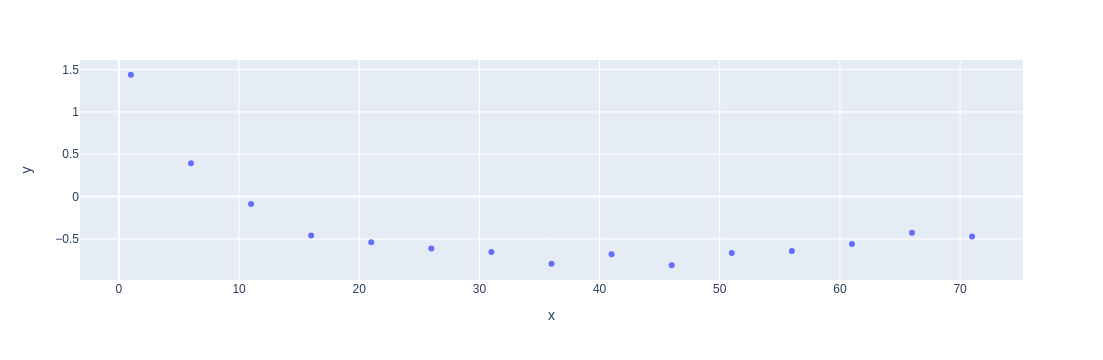

In [82]:
import plotly.express as px

n_factor = np.sum((v2_norm - 0)**2)

fig = px.scatter(x=l_vec, y=np.log10(r2_vec / n_factor * 100))
fig.show()

In [75]:
np.arange(1, 75, 5)

array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71])